In [1]:
import warnings
warnings.filterwarnings("ignore")
import pickle as pk
import pandas as pd
import wordcloud as wc
import gensim as gs
import gensim.corpora as cp
import pyLDAvis.gensim
import pyLDAvis
import numpy as np
import  matplotlib.pyplot as plt

In [2]:
covid_date = np.datetime64('2020-04-01T01:00:00.000000+0100')
n_topics = 10

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


# WordCloud

In [3]:
def word_cloud(df):
    all_words = ''
    for text in df['text']:
        all_words += ','.join(list(text)) 
        
    print('Total words {}'.format(len(all_words)))
    
    wordcloud = wc.WordCloud(background_color="white", max_words=100000, contour_width=4, scale=3, contour_color='steelblue')
    wordcloud.generate(all_words)
    return wordcloud.to_image()

# LDA

In [4]:
def lda(df, n_topics=5):
    all_words = []
    for text in df['text']:
        all_words.append(text)
    
    # Create dictionary and corpus
    word2num = cp.Dictionary(all_words)
    texts = all_words
    
    # Get term frequency
    corpus = [word2num.doc2bow(text) for text in texts]
    
    lda_model = gs.models.LdaMulticore(corpus=corpus, id2word=word2num, num_topics=n_topics)
    doc_lda = lda_model[corpus]
    
    print('\nTopics')
    print(lda_model.print_topics())
    
    print('\nScores')
    for i in range(0, len(corpus), 500):
        for index, score in sorted(lda_model[corpus[i]], key=lambda tup: -1*tup[1]):
            print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))
    
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim.prepare(lda_model, corpus, word2num)

def lda_base(df, n_topics=5):
    all_words = []
    for text in df['text']:
        all_words.append(text)
    
    # Create dictionary and corpus
    word2num = cp.Dictionary(all_words)
    texts = all_words
    
    # Get term frequency
    corpus = [word2num.doc2bow(text) for text in texts]
    
    lda_model = gs.models.LdaMulticore(corpus=corpus, id2word=word2num, num_topics=n_topics)
    doc_lda = lda_model[corpus]
    
    print('\nTopics')
    print(lda_model.print_topics())
    
    print('\nScores')
    for i in range(0, len(corpus), 500):
        for index, score in sorted(lda_model[corpus[i]], key=lambda tup: -1*tup[1]):
            print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))
    
    pyLDAvis.enable_notebook()
    return (lda_model, corpus, word2num)

# All

In [5]:
# Need to first get cleaned tokenized text data
uber_df_tk = pd.read_pickle(r'./data/uber_tk.p')
users_df=pd.read_csv('./Scraping/data/uber_users.csv')
#uber_df = pd.read_pickle(r'./Scraping/data/uber.p')

In [6]:
users=set(list(uber_df_tk['source'])+list(uber_df_tk['target']))
users = [user.lower() for user in users]

In [7]:
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

# word_lemmatizer = WordNetLemmatizer()

#Get rid of handles
for i in uber_df_tk.index:
    source=uber_df_tk['source'][i].lower().replace("_","")
    target=uber_df_tk['target'][i].lower().replace("_","")
    text=uber_df_tk['text'][i]
    
    while(source in text):
        index=text.index(source)
        del text[index]
    while(target in text):
        index=text.index(target)
        del text[index] 
    while("uber" in text):
        index=text.index("uber")
        del text[index] 
    while("httpubersupport" in text):
        index=text.index("httpubersupport")
        del text[index] 
    while("ubersupport" in text):
        index=text.index("ubersupport")
        del text[index] 
    uber_df_tk['text'][i]=text

In [8]:
uber_df_tk.groupby(["source",'created_at']).count()

source_id  target  target_id  \
source          created_at                                          
103sanaiqbal    2021-03-31 14:50:01          2       2          2   
123aviraj       2021-03-24 16:23:53          1       1          1   
1975aregr8t     2021-03-27 00:40:54          2       2          2   
                2021-03-27 02:23:36          2       2          2   
1BirdyTheMighty 2019-12-30 21:42:17          1       1          1   
...                                        ...     ...        ...   
yur             2021-03-28 00:06:34          3       3          3   
zaheea01        2021-03-26 04:28:47          1       1          1   
zeeshan90995897 2021-03-30 18:55:47          1       1          1   
                2021-03-30 18:56:32          1       1          1   
zillah7478      2021-03-31 15:00:25          4       4          4   

                                     type_of_content  all_data  text  
source          created_at                                            
103sanaiqbal    2021-03-31 14:50:01                2         2     2  
123aviraj       2021-03-24 16:23:53                1         1     1  
1975aregr8t     2021-03-27 00:40:54                2         2     2  
                2021-03-27 02:23:36                2         2     2  
1BirdyTheMighty 2019-12-30 21:42:17                1         1     1  
...                                              ...       ...   ...  
yur             2021-03-28 00:06:34                3         3     3  
zaheea01        2021-03-26 04:28:47                1         1     1  
zeeshan90995897 2021-03-30 18:55:47                1         1     1  
                2021-03-30 18:56:32                1         1     1  
zillah7478      2021-03-31 15:00:25                4         4     4  

[3951 rows x 6 columns]

In [9]:
users_df

,Unnamed: 0,user,listed,followers
0,0,Michael05914091,0,8
1,1,ShieldVoC,18,17566
2,2,fltrtae,15,1717
3,3,Lucky00890359,0,0
4,4,zhenyalindgardt,1,55
...,...,...,...,...
2573,2573,fayedicksonxo,0,213
2574,2574,Iam_bahuguna,0,90
2575,2575,ajb_neuk,0,3
2576,2576,k_sovs,0,2


In [10]:
import pickle
pickle.dump(uber_df_tk,open('./data/uber_tk.p','wb'))

In [11]:

wcloud = word_cloud(uber_df_tk)

Total words 289077


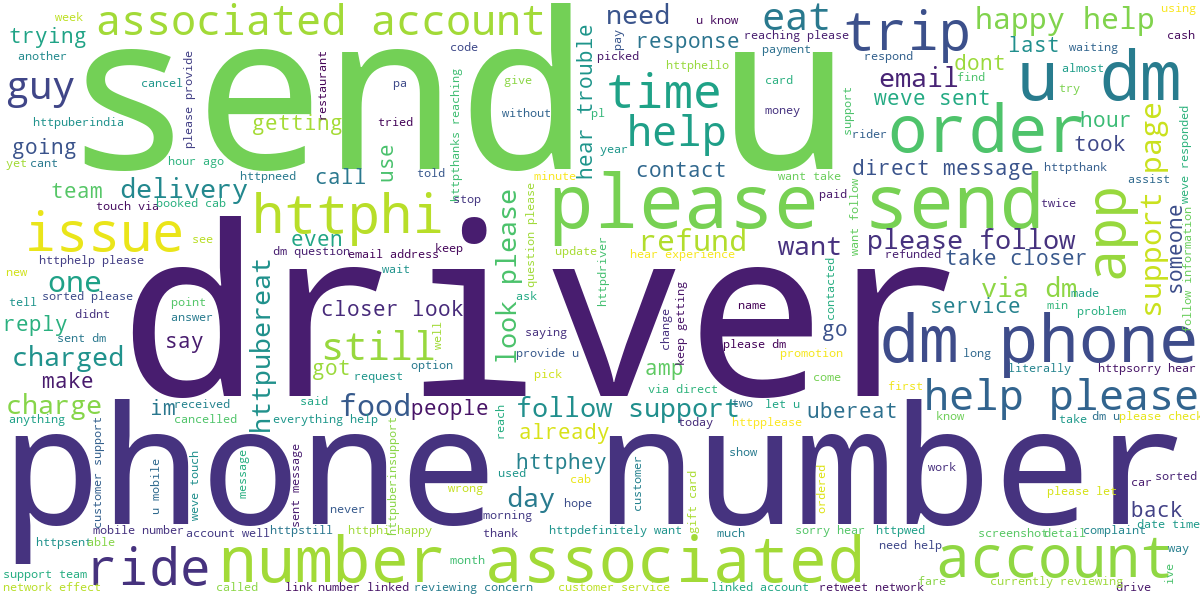

In [12]:
wcloud

In [13]:
agg=pd.read_csv("./data/all_aggregated_uber_results_2.csv")

In [14]:
lda_model, corpus, word2num=lda_base(uber_df_tk,n_topics)
alltopics=pd.DataFrame()
no_topics=10
for corp in corpus:
    topic_stuff=pd.DataFrame(lda_model[corp])
    topic=topic_stuff.T.iloc[1]
    topic.index=topic_stuff.T.iloc[0]

    actual_topic=topic_stuff.sort_values(by=1).tail(1)
    actual_topic=actual_topic[0][actual_topic.index[0]]
    topic=pd.DataFrame(topic.T).T.reset_index(drop=True)
    topic['Topic']=actual_topic
    # topic=topic_stuff.T.iloc[1].append(pd.Series(actual_topic)).reset_index(drop=True)
    alltopics=alltopics.append(topic,ignore_index=True)


Topics
[(0, '0.059*"http" + 0.026*"dm" + 0.026*"please" + 0.016*"account" + 0.015*"phone" + 0.015*"number" + 0.011*"send" + 0.011*"customer" + 0.011*"associated" + 0.011*"email"'), (1, '0.085*"http" + 0.021*"driver" + 0.019*"order" + 0.018*"help" + 0.015*"hi" + 0.014*"please" + 0.013*"account" + 0.011*"support" + 0.010*"dm" + 0.009*"u"'), (2, '0.081*"http" + 0.029*"please" + 0.025*"dm" + 0.020*"u" + 0.017*"help" + 0.014*"driver" + 0.014*"number" + 0.014*"get" + 0.013*"send" + 0.012*"phone"'), (3, '0.067*"http" + 0.025*"account" + 0.023*"help" + 0.020*"driver" + 0.016*"need" + 0.013*"please" + 0.012*"time" + 0.009*"order" + 0.009*"get" + 0.008*"number"'), (4, '0.076*"http" + 0.025*"driver" + 0.019*"help" + 0.012*"please" + 0.011*"ride" + 0.009*"issue" + 0.009*"account" + 0.009*"response" + 0.009*"dm" + 0.009*"hour"'), (5, '0.077*"http" + 0.022*"please" + 0.020*"dm" + 0.019*"u" + 0.015*"phone" + 0.014*"driver" + 0.014*"send" + 0.014*"sent" + 0.013*"number" + 0.011*"message"'), (6, '0.06

In [15]:
alltopics=alltopics.fillna(0)

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()
sentiments=[]
for topic in alltopics.index:
    negativity = SIA.polarity_scores(" ".join(uber_df_tk['text'][topic]))['neg']
    sentiments.append(negativity)

In [17]:
uber_df_tk['sentiments']=sentiments

In [18]:
convos=[]
for index in uber_df_tk.index:
    convo=" ".join(sorted([uber_df_tk['source'][index],uber_df_tk['target'][index]]))
    convos.append(convo)

In [19]:
uber_df_tk['Convo']=convos

In [86]:
import pickle
pickle.dump(uber_df_tk,open('./data/uber_tk_sent','wb'))

In [20]:
unique_convos=set(convos)

In [21]:
# all_sentdifferences=[]
all_sents=[]
for convo in unique_convos:
    involved=uber_df_tk[uber_df_tk['Convo']==convo].reset_index(drop=True)
#     sent=0
#     sentdifferences=[sent]
    sents=[]
    for i in involved.index:
#         sentdiff = sent-involved['sentiments'][i]
#         sent=involved['sentiments'][i]
#         sentdifferences.append(sentdiff)
        sents.append(involved['sentiments'][i])
    all_sents.append(sents)
#     all_sentdifferences.append(sentdifferences)

In [22]:
all_sents_df=pd.DataFrame(all_sents)

In [23]:
convo_sents=pd.DataFrame(zip(unique_convos,all_sents))

In [24]:
convo_sents[convo_sents[0].str.contains('StlGig')]

,0,1
640,StlGig dkhos,"[0.0, 0.0, 0.39, 0.0]"
1051,StlGig ksdknews,[0.0]
1806,StlGig Uber_Support,"[0.0, 0.0, 0.348, 0.0]"
3071,StlGig TODAYshow,[0.0]
3209,CNN StlGig,[0.0]


<BarContainer object of 22 artists>

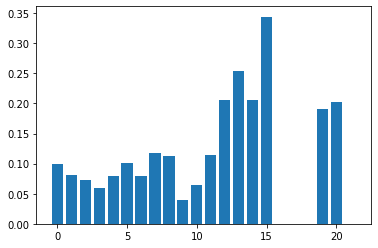

In [25]:
means=all_sents_df.mean()
plt.bar(means.index,means)

In [26]:
pd.concat([uber_df_tk[['source','target','type_of_content','created_at']],alltopics],axis=1).to_csv("formatted.csv")

In [27]:
LDAvis_prepared=pyLDAvis.gensim.prepare(lda_model, corpus, word2num)
pyLDAvis.save_html(LDAvis_prepared,'./html/all_lda_n{}.html'.format(n_topics))

# To Uber

In [28]:
to_uber_df_tk = uber_df_tk[(uber_df_tk['target'] == 'Uber_Support')|(uber_df_tk['target'] == 'UberVirgDetroit')|
                                (uber_df_tk['target'] == 'Uber_India')|(uber_df_tk['target'] == 'UberEats')|
                                (uber_df_tk['target'] == 'Uber_Kolkata')|(uber_df_tk['target'] == 'Uber')|
                                (uber_df_tk['target'] == 'UberUKsupport')|(uber_df_tk['target'] == 'Uber_MEX')|
                                (uber_df_tk['target'] == 'Uber_RSA')|(uber_df_tk['target'] == 'UberINSupport')]

In [29]:
to_uber_df_tk

,source,source_id,target,target_id,type_of_content,created_at,all_data,text,sentiments,Convo
4,SatishInnov8,722043526461145088,Uber_Support,2815754953,Reply,2019-12-09 17:11:51,{'created_at': 'Mon Dec 09 17:11:51 +0000 2019...,"[wish, respectfully, state, regular, user, usi...",0.000,SatishInnov8 Uber_Support
15,James_Carleton,247005181,Uber_Support,2815754953,Reply,2019-12-28 03:34:47,{'created_at': 'Sat Dec 28 03:34:47 +0000 2019...,"[ubereats, mcdonaldscanada, hi, team, going, a...",0.000,James_Carleton Uber_Support
16,James_Carleton,247005181,UberEats,3100005042,Reply,2019-12-28 03:34:47,{'created_at': 'Sat Dec 28 03:34:47 +0000 2019...,"[mcdonaldscanada, hi, team, going, allow, cust...",0.000,James_Carleton UberEats
18,SajeshSreejayan,96289683,Uber_Support,2815754953,Reply,2019-12-28 06:53:00,{'created_at': 'Sat Dec 28 06:53:00 +0000 2019...,"[awesome, partner, asks, destination, cancel, ...",0.165,SajeshSreejayan Uber_Support
19,iVigneshSuresh,59047875,Uber_Support,2815754953,Reply,2019-12-28 09:56:17,{'created_at': 'Sat Dec 28 09:56:17 +0000 2019...,"[uberindia, apart, screenshot, also, get, pls,...",0.095,Uber_Support iVigneshSuresh
...,...,...,...,...,...,...,...,...,...,...
5562,Iam_bahuguna,1094093461631000576,Uber_Support,2815754953,Reply,2021-03-31 17:09:05,{'created_at': 'Wed Mar 31 17:09:05 +0000 2021...,"[refused, move, even, minute, asking, cancel, ...",0.288,Iam_bahuguna Uber_Support
5563,ajb_neuk,1344742630731747328,Uber_Support,2815754953,Reply,2021-03-31 17:15:48,{'created_at': 'Wed Mar 31 17:15:48 +0000 2021...,"[yeah, cause, link, useful, support, quick, lo...",0.154,Uber_Support ajb_neuk
5564,AdrianMatache7,1376698104028794882,Uber_Support,2815754953,Reply,2021-03-31 17:18:34,{'created_at': 'Wed Mar 31 17:18:34 +0000 2021...,"[hi, guy, long, take, bank, account, reviewed,...",0.000,AdrianMatache7 Uber_Support
5565,k_sovs,1369169148580823040,Uber_Support,2815754953,Reply,2021-03-31 17:19:01,{'created_at': 'Wed Mar 31 17:19:01 +0000 2021...,"[filled, form, many, time, response]",0.000,Uber_Support k_sovs


In [30]:
wcloud = word_cloud(to_uber_df_tk)

Total words 192117


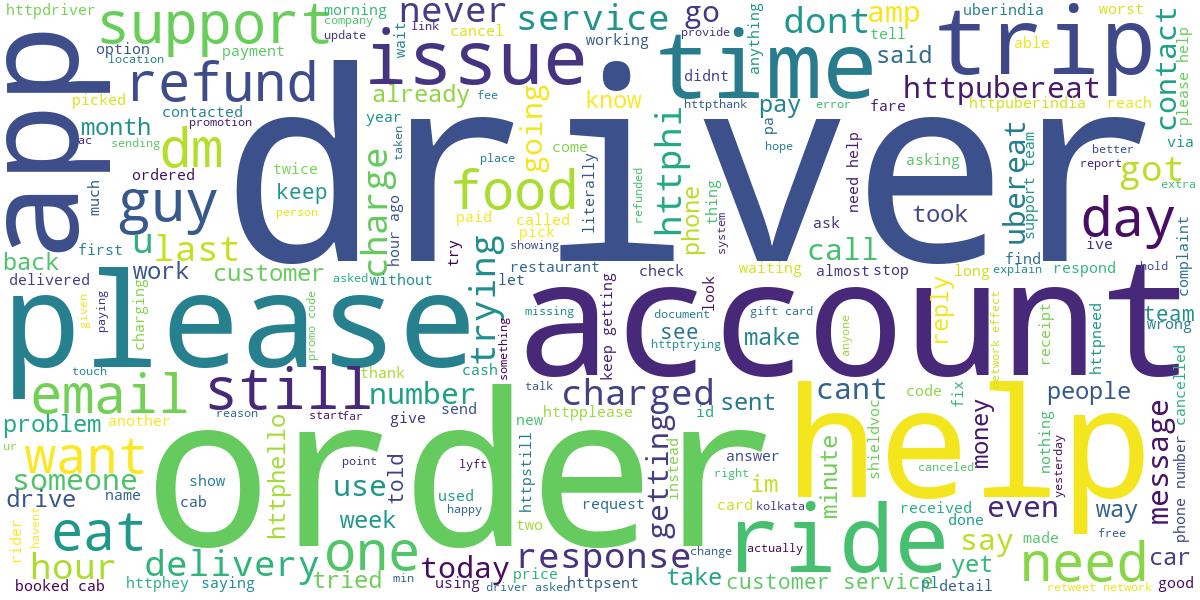

In [31]:
wcloud

In [32]:
LDAvis_prepared = lda(to_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.090*"http" + 0.029*"driver" + 0.012*"help" + 0.012*"order" + 0.009*"issue" + 0.007*"still" + 0.007*"get" + 0.007*"food" + 0.006*"guy" + 0.006*"ride"'), (1, '0.065*"http" + 0.029*"help" + 0.024*"please" + 0.013*"need" + 0.012*"account" + 0.011*"order" + 0.010*"thank" + 0.009*"driver" + 0.008*"ride" + 0.008*"customer"'), (2, '0.065*"http" + 0.023*"driver" + 0.012*"order" + 0.010*"time" + 0.009*"account" + 0.008*"app" + 0.008*"message" + 0.007*"im" + 0.007*"cab" + 0.007*"ubereats"'), (3, '0.091*"http" + 0.015*"please" + 0.015*"dm" + 0.014*"driver" + 0.011*"sent" + 0.009*"hi" + 0.009*"trip" + 0.009*"time" + 0.009*"account" + 0.008*"uberindia"'), (4, '0.058*"http" + 0.020*"driver" + 0.016*"get" + 0.012*"order" + 0.012*"dm" + 0.011*"help" + 0.010*"app" + 0.010*"sent" + 0.010*"refund" + 0.010*"still"'), (5, '0.078*"http" + 0.018*"driver" + 0.012*"order" + 0.010*"get" + 0.009*"ride" + 0.009*"issue" + 0.009*"account" + 0.009*"ubereats" + 0.008*"trying" + 0.007*"phone"'), (6, '0.

In [33]:
LDAvis_prepared[3]

30

In [34]:
pyLDAvis.save_html(LDAvis_prepared,'./html/to_lda_n{}.html'.format(n_topics))

# From Uber

In [35]:
from_uber_df_tk = uber_df_tk[(uber_df_tk['source'] == 'Uber_Support')|(uber_df_tk['source'] == 'UberVirgDetroit')|
                                (uber_df_tk['source'] == 'Uber_India')|(uber_df_tk['source'] == 'UberEats')|
                                (uber_df_tk['source'] == 'Uber_Kolkata')|(uber_df_tk['source'] == 'Uber')|
                                (uber_df_tk['source'] == 'UberUKsupport')|(uber_df_tk['source'] == 'Uber_MEX')|
                                (uber_df_tk['source'] == 'Uber_RSA')|(uber_df_tk['source'] == 'UberINSupport')]

In [36]:
from_uber_df_tk

,source,source_id,target,target_id,type_of_content,created_at,all_data,text,sentiments,Convo
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.0,Uber_Support wordofbrandon
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.0,Uber_Support wordofbrandon
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.0,CapeVgirl Uber_Support
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.0,CapeVgirl Uber_Support
5,Uber_Support,2815754953,realchetty,28766827,Reply,2019-12-20 12:02:54,{'created_at': 'Fri Dec 20 12:02:54 +0000 2019...,"[definitely, want, ensure, addressed, appropri...",0.0,Uber_Support realchetty
...,...,...,...,...,...,...,...,...,...,...
5551,Uber_Support,2815754953,CVREENSWORLD,1352048476339761153,Reply,2021-03-31 16:54:36,{'created_at': 'Wed Mar 31 16:54:36 +0000 2021...,"[hi, cvreeny, happy, help, please, follow, sup...",0.0,CVREENSWORLD Uber_Support
5552,Uber_Support,2815754953,makaylabez,303867642,Reply,2021-03-31 16:55:35,{'created_at': 'Wed Mar 31 16:55:35 +0000 2021...,"[happy, help, makayla, please, send, u, additi...",0.0,Uber_Support makaylabez
5553,Uber_Support,2815754953,ajb_neuk,1344742630731747328,Reply,2021-03-31 16:55:49,{'created_at': 'Wed Mar 31 16:55:49 +0000 2021...,"[hi, happy, help, please, follow, support, pag...",0.0,Uber_Support ajb_neuk
5554,Uber_Support,2815754953,Nezz911,429610920,Reply,2021-03-31 16:57:30,{'created_at': 'Wed Mar 31 16:57:30 +0000 2021...,"[hi, neo, assist]",0.0,Nezz911 Uber_Support


In [37]:
wcloud = word_cloud(from_uber_df_tk)

Total words 72101


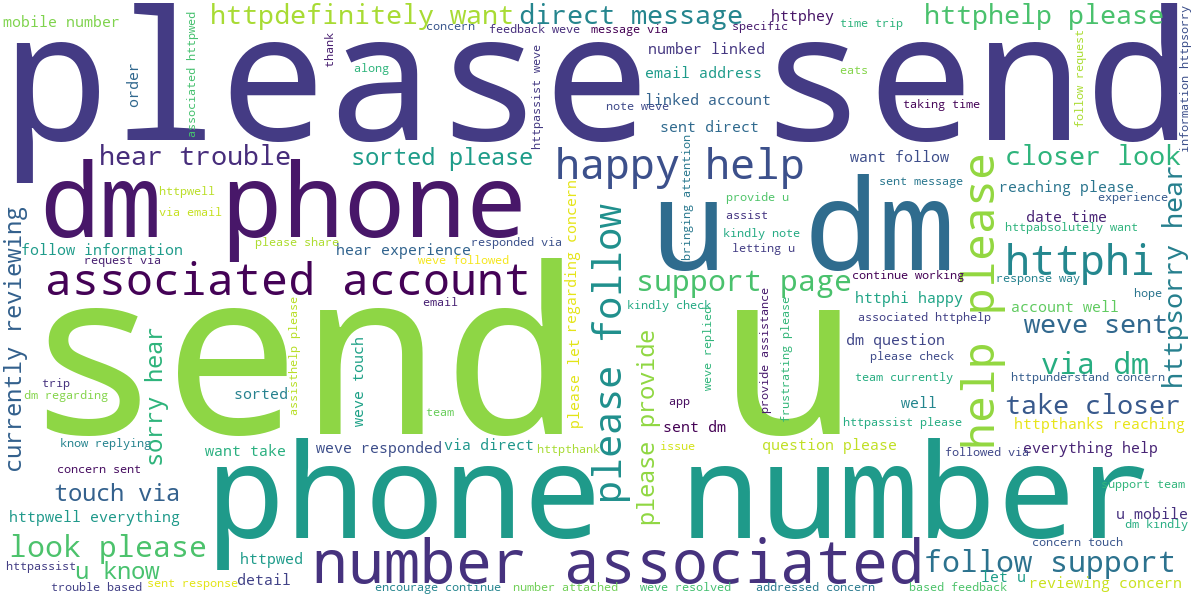

In [38]:
wcloud

In [39]:
LDAvis_prepared = lda(from_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.058*"dm" + 0.053*"please" + 0.043*"http" + 0.041*"via" + 0.039*"assist" + 0.037*"weve" + 0.033*"u" + 0.032*"number" + 0.030*"message" + 0.027*"phone"'), (1, '0.100*"http" + 0.047*"please" + 0.028*"follow" + 0.027*"help" + 0.025*"phone" + 0.025*"hi" + 0.022*"account" + 0.021*"thanks" + 0.021*"number" + 0.021*"dm"'), (2, '0.085*"http" + 0.055*"u" + 0.045*"please" + 0.035*"dm" + 0.035*"number" + 0.035*"send" + 0.033*"phone" + 0.031*"help" + 0.022*"sorry" + 0.021*"hear"'), (3, '0.071*"u" + 0.067*"http" + 0.057*"please" + 0.054*"send" + 0.045*"dm" + 0.042*"phone" + 0.041*"number" + 0.038*"associated" + 0.032*"help" + 0.028*"well"'), (4, '0.100*"http" + 0.066*"please" + 0.046*"help" + 0.037*"follow" + 0.032*"hi" + 0.030*"support" + 0.027*"happy" + 0.027*"page" + 0.026*"u" + 0.021*"dm"'), (5, '0.107*"http" + 0.049*"please" + 0.043*"like" + 0.036*"follow" + 0.030*"number" + 0.028*"look" + 0.027*"u" + 0.026*"phone" + 0.023*"send" + 0.023*"wed"'), (6, '0.083*"http" + 0.045*"pleas

In [40]:
pyLDAvis.save_html(LDAvis_prepared,'./html/from_lda_n{}.html'.format(n_topics))

# To Uber Pre-COVID

In [41]:
pre_to_uber_df_tk = uber_df_tk[((uber_df_tk['target'] == 'Uber_Support')|(uber_df_tk['target'] == 'UberVirgDetroit')|
                                (uber_df_tk['target'] == 'Uber_India')|(uber_df_tk['target'] == 'UberEats')|
                                (uber_df_tk['target'] == 'Uber_Kolkata')|(uber_df_tk['target'] == 'Uber')|
                                (uber_df_tk['target'] == 'UberUKsupport')|(uber_df_tk['target'] == 'Uber_MEX')|
                                (uber_df_tk['target'] == 'Uber_RSA')|(uber_df_tk['target'] == 'UberINSupport')
                               ) & (uber_df_tk['created_at'] <= covid_date)]

In [42]:
wcloud = word_cloud(pre_to_uber_df_tk)

Total words 30113


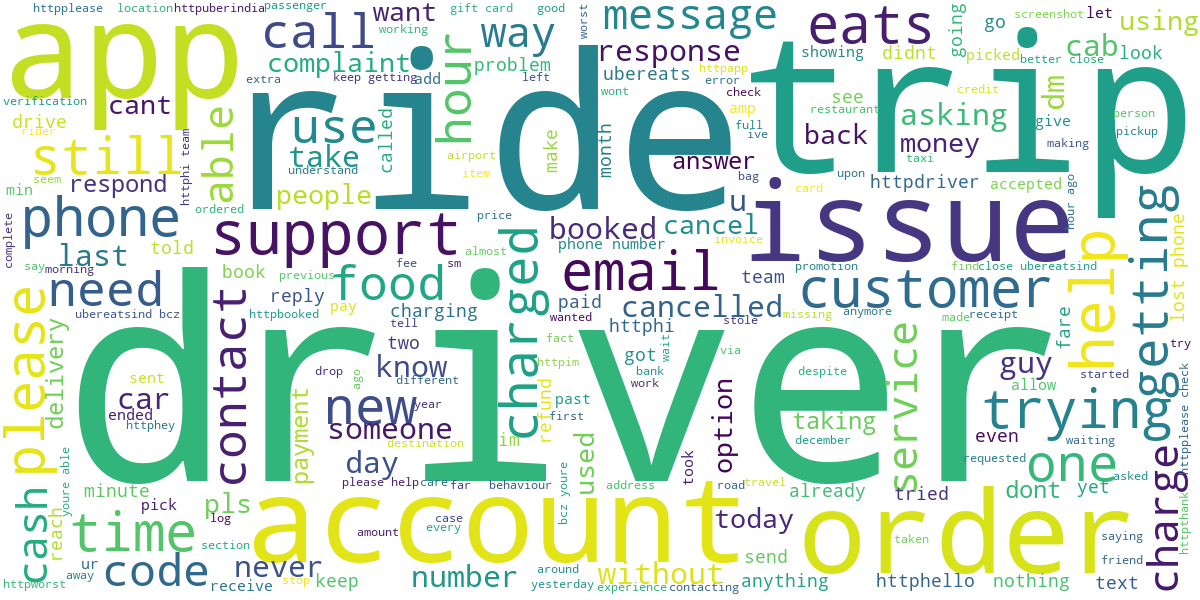

In [43]:
wcloud

In [44]:
LDAvis_prepared = lda(pre_to_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.029*"http" + 0.019*"refund" + 0.015*"driver" + 0.011*"passenger" + 0.011*"able" + 0.008*"please" + 0.008*"case" + 0.008*"need" + 0.008*"order" + 0.008*"uberindia"'), (1, '0.075*"http" + 0.019*"phone" + 0.016*"driver" + 0.013*"app" + 0.010*"uberindia" + 0.010*"ride" + 0.009*"since" + 0.009*"getting" + 0.009*"help" + 0.008*"hour"'), (2, '0.054*"http" + 0.042*"driver" + 0.016*"help" + 0.015*"get" + 0.013*"app" + 0.011*"someone" + 0.010*"please" + 0.008*"paid" + 0.007*"need" + 0.007*"pls"'), (3, '0.061*"http" + 0.026*"order" + 0.020*"app" + 0.015*"eats" + 0.015*"issue" + 0.014*"get" + 0.010*"hi" + 0.009*"trip" + 0.009*"service" + 0.008*"cab"'), (4, '0.044*"http" + 0.028*"please" + 0.024*"help" + 0.018*"dm" + 0.016*"account" + 0.016*"need" + 0.013*"driver" + 0.009*"let" + 0.008*"order" + 0.008*"ride"'), (5, '0.054*"http" + 0.029*"driver" + 0.018*"trip" + 0.010*"support" + 0.010*"ride" + 0.010*"charge" + 0.008*"see" + 0.008*"one" + 0.007*"im" + 0.006*"contact"'), (6, '0.074*"

In [45]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.060337 -0.093881       1        1  14.571165
3     -0.037757 -0.043585       2        1  13.721283
6      0.085693 -0.040161       3        1  13.202081
7      0.021810 -0.032588       4        1  12.219901
2      0.019462  0.069562       5        1  10.291266
9     -0.104422  0.025600       6        1   9.498003
4     -0.040549  0.080280       7        1   8.133591
5      0.123158  0.016982       8        1   7.818182
8      0.001155 -0.056409       9        1   6.652096
0     -0.008214  0.074199      10        1   3.892432, topic_info=          Term       Freq      Total Category  logprob  loglift
177      phone  30.000000  30.000000  Default  30.0000  30.0000
88        help  35.000000  35.000000  Default  29.0000  29.0000
119     driver  86.000000  86.000000  Default  28.0000  28.0000
49          dm  18.000000  18.000000  Default  27.0000  27.0000
301     refund  11.000000  11.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
18    ubereats   0.729032  12.701411  Topic10  -5.5233   0.3884
177      phone   0.729032  30.928759  Topic10  -5.5233  -0.5016
245      claim   0.729032   2.226972  Topic10  -5.5233   2.1295
548  mcdonalds   0.729031   2.186317  Topic10  -5.5233   2.1479
268    vehicle   0.729030   3.829734  Topic10  -5.5233   1.5873

[713 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
383       1  0.176112   able
383       2  0.117408   able
383       3  0.058704   able
383       4  0.176112   able
383       5  0.058704   able
...     ...       ...    ...
780       6  0.629951  youre
888       3  0.885315     yr
1042      1  0.827593   zero
926       1  0.622639   über
926       2  0.311320   über

[1272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 7, 8, 3, 10, 5, 6, 9, 1])

In [46]:
pyLDAvis.save_html(LDAvis_prepared,'./html/pre_to_lda_n{}.html'.format(n_topics))

# To Uber Post-COVID

In [47]:
post_to_uber_df_tk = uber_df_tk[(uber_df_tk['target'] == 'Uber_Support')|(uber_df_tk['target'] == 'UberVirgDetroit')|
                                (uber_df_tk['target'] == 'Uber_India')|(uber_df_tk['target'] == 'UberEats')|
                                (uber_df_tk['target'] == 'Uber_Kolkata')|(uber_df_tk['target'] == 'Uber')|
                                (uber_df_tk['target'] == 'UberUKsupport')|(uber_df_tk['target'] == 'Uber_MEX')|
                                (uber_df_tk['target'] == 'Uber_RSA')|(uber_df_tk['target'] == 'UberINSupport') & (uber_df_tk['created_at'] > covid_date)]

In [48]:
post_to_uber_df_tk

,source,source_id,target,target_id,type_of_content,created_at,all_data,text,sentiments,Convo
4,SatishInnov8,722043526461145088,Uber_Support,2815754953,Reply,2019-12-09 17:11:51,{'created_at': 'Mon Dec 09 17:11:51 +0000 2019...,"[wish, respectfully, state, regular, user, usi...",0.000,SatishInnov8 Uber_Support
15,James_Carleton,247005181,Uber_Support,2815754953,Reply,2019-12-28 03:34:47,{'created_at': 'Sat Dec 28 03:34:47 +0000 2019...,"[ubereats, mcdonaldscanada, hi, team, going, a...",0.000,James_Carleton Uber_Support
16,James_Carleton,247005181,UberEats,3100005042,Reply,2019-12-28 03:34:47,{'created_at': 'Sat Dec 28 03:34:47 +0000 2019...,"[mcdonaldscanada, hi, team, going, allow, cust...",0.000,James_Carleton UberEats
18,SajeshSreejayan,96289683,Uber_Support,2815754953,Reply,2019-12-28 06:53:00,{'created_at': 'Sat Dec 28 06:53:00 +0000 2019...,"[awesome, partner, asks, destination, cancel, ...",0.165,SajeshSreejayan Uber_Support
19,iVigneshSuresh,59047875,Uber_Support,2815754953,Reply,2019-12-28 09:56:17,{'created_at': 'Sat Dec 28 09:56:17 +0000 2019...,"[uberindia, apart, screenshot, also, get, pls,...",0.095,Uber_Support iVigneshSuresh
...,...,...,...,...,...,...,...,...,...,...
5562,Iam_bahuguna,1094093461631000576,Uber_Support,2815754953,Reply,2021-03-31 17:09:05,{'created_at': 'Wed Mar 31 17:09:05 +0000 2021...,"[refused, move, even, minute, asking, cancel, ...",0.288,Iam_bahuguna Uber_Support
5563,ajb_neuk,1344742630731747328,Uber_Support,2815754953,Reply,2021-03-31 17:15:48,{'created_at': 'Wed Mar 31 17:15:48 +0000 2021...,"[yeah, cause, link, useful, support, quick, lo...",0.154,Uber_Support ajb_neuk
5564,AdrianMatache7,1376698104028794882,Uber_Support,2815754953,Reply,2021-03-31 17:18:34,{'created_at': 'Wed Mar 31 17:18:34 +0000 2021...,"[hi, guy, long, take, bank, account, reviewed,...",0.000,AdrianMatache7 Uber_Support
5565,k_sovs,1369169148580823040,Uber_Support,2815754953,Reply,2021-03-31 17:19:01,{'created_at': 'Wed Mar 31 17:19:01 +0000 2021...,"[filled, form, many, time, response]",0.000,Uber_Support k_sovs


In [49]:
wcloud = word_cloud(from_uber_df_tk)

Total words 72101


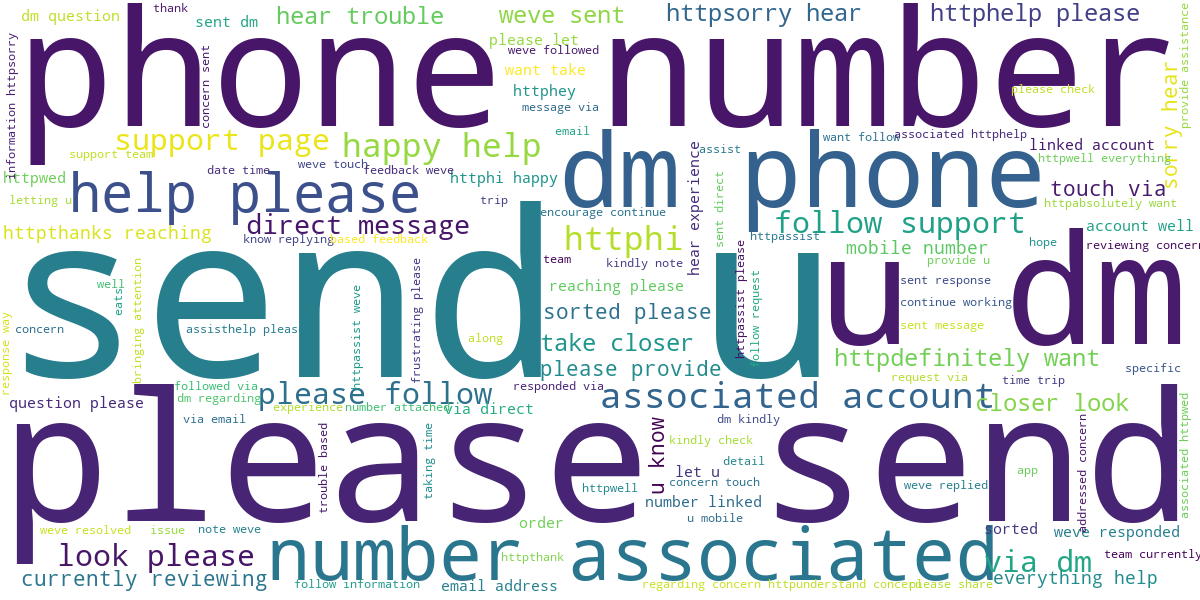

In [50]:
wcloud

In [51]:
LDAvis_prepared = lda(post_to_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.076*"http" + 0.037*"driver" + 0.014*"dm" + 0.012*"please" + 0.012*"trip" + 0.008*"get" + 0.007*"day" + 0.007*"cancelled" + 0.006*"keep" + 0.006*"time"'), (1, '0.074*"http" + 0.020*"help" + 0.017*"driver" + 0.016*"charged" + 0.014*"need" + 0.014*"dm" + 0.014*"order" + 0.013*"guy" + 0.009*"ride" + 0.009*"charge"'), (2, '0.073*"http" + 0.014*"driver" + 0.012*"order" + 0.010*"service" + 0.009*"app" + 0.007*"ubereats" + 0.007*"get" + 0.006*"delivery" + 0.006*"month" + 0.006*"go"'), (3, '0.064*"http" + 0.020*"help" + 0.019*"order" + 0.014*"issue" + 0.012*"please" + 0.011*"account" + 0.011*"driver" + 0.011*"need" + 0.009*"support" + 0.009*"service"'), (4, '0.081*"http" + 0.025*"driver" + 0.011*"number" + 0.011*"uberinsupport" + 0.011*"uberindia" + 0.010*"dm" + 0.010*"trip" + 0.009*"time" + 0.009*"today" + 0.008*"response"'), (5, '0.083*"http" + 0.015*"help" + 0.014*"driver" + 0.012*"ride" + 0.012*"account" + 0.011*"app" + 0.011*"order" + 0.009*"please" + 0.009*"support" + 0.00

In [52]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.004476  0.003355       1        1  16.819494
4     -0.043631 -0.047984       2        1  10.917186
8     -0.021560  0.005538       3        1  10.724459
1      0.012614 -0.004435       4        1  10.370656
3      0.057374  0.012977       5        1  10.121543
6     -0.009610 -0.040295       6        1   9.755134
7      0.077523 -0.072433       7        1   8.061759
9     -0.008495  0.081053       8        1   7.976232
0     -0.098596 -0.010723       9        1   7.834767
2      0.029907  0.072946      10        1   7.418770, topic_info=        Term        Freq       Total Category  logprob  loglift
29       get  228.000000  228.000000  Default  30.0000  30.0000
49        dm  200.000000  200.000000  Default  29.0000  29.0000
119   driver  537.000000  537.000000  Default  28.0000  28.0000
214  charged  103.000000  103.000000  Default  27.0000  27.0000
135     trip  174.000000  174.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
88      help   11.256286  290.206608  Topic10  -5.2803  -0.6485
177    phone    8.861618  105.218806  Topic10  -5.5195   0.1268
195     call    8.042220   84.336307  Topic10  -5.6165   0.2510
102     sent    8.041581  152.172170  Topic10  -5.6166  -0.3392
98      ride    7.660944  190.258334  Topic10  -5.6651  -0.6111

[828 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3114      8  0.541318  aapkagopalrai
1893      6  0.783118         abduct
383       1  0.059168           able
383       2  0.118336           able
383       3  0.059168           able
...     ...       ...            ...
780       5  0.072857          youre
780       6  0.145713          youre
780       7  0.437139          youre
780       8  0.072857          youre
780      10  0.072857          youre

[2183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 9, 2, 4, 7, 8, 10, 1, 3])

In [53]:
pyLDAvis.save_html(LDAvis_prepared,'./html/post_to_lda_n{}.html'.format(n_topics))

# From Uber Pre-COVID

In [54]:
pre_from_uber_df_tk = uber_df_tk[(uber_df_tk['source'] == 'Uber_Support') & (uber_df_tk['created_at'] <= covid_date)]

In [55]:
pre_from_uber_df_tk

,source,source_id,target,target_id,type_of_content,created_at,all_data,text,sentiments,Convo
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.0,Uber_Support wordofbrandon
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.0,Uber_Support wordofbrandon
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.0,CapeVgirl Uber_Support
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.0,CapeVgirl Uber_Support
5,Uber_Support,2815754953,realchetty,28766827,Reply,2019-12-20 12:02:54,{'created_at': 'Fri Dec 20 12:02:54 +0000 2019...,"[definitely, want, ensure, addressed, appropri...",0.0,Uber_Support realchetty
...,...,...,...,...,...,...,...,...,...,...
651,Uber_Support,2815754953,lordsarcastico,141914172,Reply,2019-12-31 23:07:11,{'created_at': 'Tue Dec 31 23:07:11 +0000 2019...,"[take, closer, look, please, send, u, detail, ...",0.0,Uber_Support lordsarcastico
652,Uber_Support,2815754953,lordsarcastico,141914172,Reply,2019-12-31 23:07:11,{'created_at': 'Tue Dec 31 23:07:11 +0000 2019...,"[take, closer, look, please, send, u, detail, ...",0.0,Uber_Support lordsarcastico
654,Uber_Support,2815754953,Bigmanpfc,21190526,Reply,2019-12-31 23:26:05,{'created_at': 'Tue Dec 31 23:26:05 +0000 2019...,"[definitely, understand, concern, however, abl...",0.0,Bigmanpfc Uber_Support
662,Uber_Support,2815754953,matdel69,1237136270767382529,Reply,2020-03-09 22:13:45,{'created_at': 'Mon Mar 09 22:13:45 +0000 2020...,"[absolutely, want, take, closer, look, please,...",0.0,Uber_Support matdel69


In [56]:
wcloud = word_cloud(pre_from_uber_df_tk)

Total words 6005


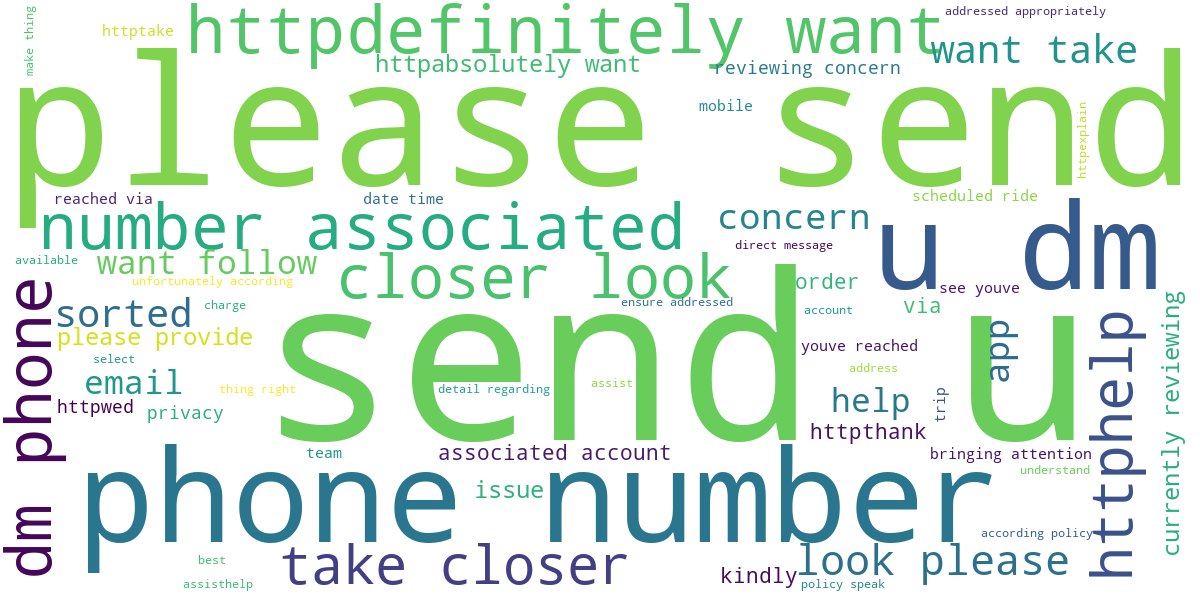

In [57]:
wcloud

In [58]:
LDAvis_prepared = lda(pre_from_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.087*"http" + 0.044*"help" + 0.044*"explain" + 0.030*"fee" + 0.030*"request" + 0.030*"match" + 0.030*"app" + 0.030*"driver" + 0.030*"specific" + 0.030*"restaurant"'), (1, '0.063*"help" + 0.063*"dm" + 0.033*"please" + 0.033*"phone" + 0.033*"send" + 0.033*"assist" + 0.033*"u" + 0.033*"number" + 0.033*"well" + 0.033*"everything"'), (2, '0.049*"http" + 0.037*"take" + 0.037*"help" + 0.037*"closer" + 0.035*"look" + 0.035*"dm" + 0.035*"u" + 0.032*"email" + 0.019*"absolutely" + 0.019*"privacy"'), (3, '0.092*"http" + 0.064*"want" + 0.052*"u" + 0.049*"definitely" + 0.046*"please" + 0.034*"send" + 0.031*"number" + 0.022*"help" + 0.022*"follow" + 0.021*"phone"'), (4, '0.091*"http" + 0.040*"help" + 0.027*"order" + 0.027*"definitely" + 0.027*"concern" + 0.027*"want" + 0.027*"sorted" + 0.027*"understand" + 0.027*"best" + 0.027*"get"'), (5, '0.080*"http" + 0.041*"understand" + 0.041*"concern" + 0.021*"please" + 0.021*"definitely" + 0.021*"reviewing" + 0.021*"issue" + 0.021*"bringing" + 

In [59]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.162825  0.017177       1        1  24.469078
3      0.071905 -0.064758       2        1  20.999286
7      0.113664  0.016048       3        1  12.390720
8      0.127745 -0.042293       4        1  12.087655
4     -0.112779 -0.116950       5        1   8.487686
0     -0.188735  0.127442       6        1   6.650014
9     -0.064771  0.017163       7        1   4.733416
5     -0.142101 -0.104259       8        1   4.717094
2      0.022450  0.088830       9        1   3.081290
1      0.009797  0.061600      10        1   2.383761, topic_info=        Term       Freq      Total Category  logprob  loglift
22        dm  27.000000  27.000000  Default  30.0000  30.0000
8       help  28.000000  28.000000  Default  29.0000  29.0000
28         u  41.000000  41.000000  Default  28.0000  28.0000
3       http  70.000000  70.000000  Default  27.0000  27.0000
24    number  30.000000  30.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
104   policy   0.067174   5.316810  Topic10  -5.8109  -0.6349
23    follow   0.067172   7.043204  Topic10  -5.8110  -0.9161
32     order   0.067172   6.106407  Topic10  -5.8110  -0.7734
100  account   0.067172  11.466348  Topic10  -5.8110  -1.4034
41     email   0.067171   7.274256  Topic10  -5.8110  -0.9484

[452 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
182       8  0.567518        able
51        1  0.622731  absolutely
51        2  0.103788  absolutely
51        4  0.103788  absolutely
51        9  0.103788  absolutely
...     ...       ...         ...
45        9  0.435793     working
99        8  0.567514       youre
125       1  0.423678       youve
125       2  0.211839       youve
125       3  0.211839       youve

[410 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 8, 9, 5, 1, 10, 6, 3, 2])

In [60]:
pyLDAvis.save_html(LDAvis_prepared,'./html/pre_from_lda_n{}.html'.format(n_topics))

# From Uber Post-COVID

In [61]:
post_from_uber_df_tk = uber_df_tk[(uber_df_tk['source'] == 'Uber_Support')|(uber_df_tk['source'] == 'UberVirgDetroit')|
                                (uber_df_tk['source'] == 'Uber_India')|(uber_df_tk['source'] == 'UberEats')|
                                (uber_df_tk['source'] == 'Uber_Kolkata')|(uber_df_tk['source'] == 'Uber')|
                                (uber_df_tk['source'] == 'UberUKsupport')|(uber_df_tk['source'] == 'Uber_MEX')|
                                (uber_df_tk['source'] == 'Uber_RSA')|(uber_df_tk['source'] == 'UberINSupport') & (uber_df_tk['created_at'] > covid_date)]

In [62]:
post_from_uber_df_tk

,source,source_id,target,target_id,type_of_content,created_at,all_data,text,sentiments,Convo
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.0,Uber_Support wordofbrandon
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.0,Uber_Support wordofbrandon
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.0,CapeVgirl Uber_Support
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.0,CapeVgirl Uber_Support
5,Uber_Support,2815754953,realchetty,28766827,Reply,2019-12-20 12:02:54,{'created_at': 'Fri Dec 20 12:02:54 +0000 2019...,"[definitely, want, ensure, addressed, appropri...",0.0,Uber_Support realchetty
...,...,...,...,...,...,...,...,...,...,...
5551,Uber_Support,2815754953,CVREENSWORLD,1352048476339761153,Reply,2021-03-31 16:54:36,{'created_at': 'Wed Mar 31 16:54:36 +0000 2021...,"[hi, cvreeny, happy, help, please, follow, sup...",0.0,CVREENSWORLD Uber_Support
5552,Uber_Support,2815754953,makaylabez,303867642,Reply,2021-03-31 16:55:35,{'created_at': 'Wed Mar 31 16:55:35 +0000 2021...,"[happy, help, makayla, please, send, u, additi...",0.0,Uber_Support makaylabez
5553,Uber_Support,2815754953,ajb_neuk,1344742630731747328,Reply,2021-03-31 16:55:49,{'created_at': 'Wed Mar 31 16:55:49 +0000 2021...,"[hi, happy, help, please, follow, support, pag...",0.0,Uber_Support ajb_neuk
5554,Uber_Support,2815754953,Nezz911,429610920,Reply,2021-03-31 16:57:30,{'created_at': 'Wed Mar 31 16:57:30 +0000 2021...,"[hi, neo, assist]",0.0,Nezz911 Uber_Support


In [63]:
wcloud = word_cloud(post_from_uber_df_tk)

Total words 72101


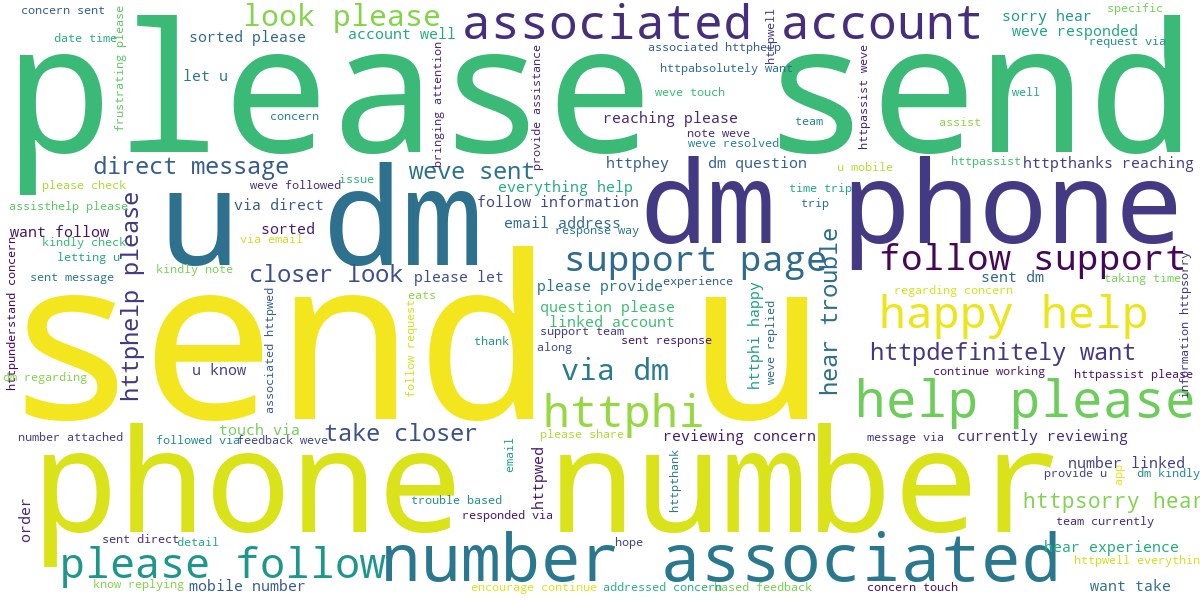

In [64]:
wcloud

In [65]:
LDAvis_prepared = lda(post_from_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.066*"http" + 0.041*"follow" + 0.040*"help" + 0.037*"dm" + 0.036*"message" + 0.034*"weve" + 0.032*"via" + 0.029*"hi" + 0.027*"please" + 0.025*"direct"'), (1, '0.055*"http" + 0.039*"please" + 0.034*"u" + 0.034*"dm" + 0.032*"phone" + 0.028*"weve" + 0.028*"send" + 0.025*"assist" + 0.024*"number" + 0.021*"message"'), (2, '0.052*"http" + 0.039*"help" + 0.036*"dm" + 0.030*"weve" + 0.026*"hi" + 0.023*"currently" + 0.022*"please" + 0.020*"concern" + 0.017*"reviewing" + 0.017*"replied"'), (3, '0.069*"http" + 0.046*"u" + 0.045*"please" + 0.032*"number" + 0.032*"dm" + 0.032*"send" + 0.026*"phone" + 0.025*"hi" + 0.022*"concern" + 0.017*"understand"'), (4, '0.129*"http" + 0.058*"please" + 0.056*"help" + 0.053*"hi" + 0.051*"support" + 0.050*"happy" + 0.045*"page" + 0.045*"follow" + 0.017*"hey" + 0.013*"sorry"'), (5, '0.072*"http" + 0.057*"u" + 0.049*"please" + 0.034*"number" + 0.029*"phone" + 0.027*"dm" + 0.022*"help" + 0.022*"send" + 0.021*"look" + 0.020*"like"'), (6, '0.113*"http" +

In [66]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.171768  0.017352       1        1  35.603760
7      0.070070  0.001071       2        1  13.504737
0     -0.034833  0.020560       3        1  10.358321
4     -0.104544  0.114527       4        1   9.431299
6     -0.008897  0.074008       5        1   7.678483
5      0.063464 -0.043288       6        1   6.325547
1      0.024746 -0.037933       7        1   6.026180
3      0.045241 -0.019415       8        1   5.080384
2     -0.106906 -0.029031       9        1   3.009518
9     -0.120109 -0.097851      10        1   2.981771, topic_info=        Term        Freq       Total Category  logprob  loglift
3       http  921.000000  921.000000  Default  30.0000  30.0000
8       help  323.000000  323.000000  Default  29.0000  29.0000
28         u  525.000000  525.000000  Default  28.0000  28.0000
192     weve  151.000000  151.000000  Default  27.0000  27.0000
173       hi  205.000000  205.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
100  account    3.306107  176.743665  Topic10  -4.6499  -0.4663
22        dm    3.306990  501.663234  Topic10  -4.6496  -1.5092
29    assist    2.789022  160.301064  Topic10  -4.8200  -0.5387
23    follow    2.239171  189.726180  Topic10  -5.0396  -0.9268
114     time    2.239078   33.068788  Topic10  -5.0396   0.8201

[685 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
674       8  0.554352  abhijeet
445      10  0.495495   abhisek
184       2  0.051823      able
184       3  0.466408      able
184       4  0.051823      able
...     ...       ...       ...
670       6  0.602066      youd
236       3  0.510161     youll
331       2  0.476138       zac
208       3  0.501862      zaid
208       9  0.250931      zaid

[1211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 1, 5, 7, 6, 2, 4, 3, 10])

In [67]:
pyLDAvis.save_html(LDAvis_prepared,'./html/post_from_lda_n{}.html'.format(n_topics))

# Pre-COVID

In [68]:
pre_uber_df_tk = uber_df_tk[uber_df_tk['created_at'] <= covid_date]

In [69]:
pre_uber_df_tk

,source,source_id,target,target_id,type_of_content,created_at,all_data,text,sentiments,Convo
0,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.000,Uber_Support wordofbrandon
1,Uber_Support,2815754953,wordofbrandon,2566081240,Reply,2019-08-31 10:53:53,{'created_at': 'Sat Aug 31 10:53:53 +0000 2019...,"[thanks, bringing, attention, team, currently,...",0.000,Uber_Support wordofbrandon
2,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.000,CapeVgirl Uber_Support
3,Uber_Support,2815754953,CapeVgirl,719534538,Reply,2019-10-01 07:45:30,{'created_at': 'Tue Oct 01 07:45:30 +0000 2019...,"[help, suggest, restarting, app, work, reset, ...",0.000,CapeVgirl Uber_Support
4,SatishInnov8,722043526461145088,Uber_Support,2815754953,Reply,2019-12-09 17:11:51,{'created_at': 'Mon Dec 09 17:11:51 +0000 2019...,"[wish, respectfully, state, regular, user, usi...",0.000,SatishInnov8 Uber_Support
...,...,...,...,...,...,...,...,...,...,...
659,lordsarcastico,141914172,Uber_Support,2815754953,Reply,2019-12-31 23:58:55,{'created_at': 'Tue Dec 31 23:58:55 +0000 2019...,"[hi, still, asking, question, please, name, co...",0.152,Uber_Support lordsarcastico
660,lordsarcastico,141914172,Uber,19103481,Reply,2019-12-31 23:58:55,{'created_at': 'Tue Dec 31 23:58:55 +0000 2019...,"[hi, still, asking, question, please, name, co...",0.152,Uber lordsarcastico
661,lordsarcastico,141914172,dkhos,41642329,Reply,2019-12-31 23:58:55,{'created_at': 'Tue Dec 31 23:58:55 +0000 2019...,"[hi, still, asking, question, please, name, co...",0.163,dkhos lordsarcastico
662,Uber_Support,2815754953,matdel69,1237136270767382529,Reply,2020-03-09 22:13:45,{'created_at': 'Mon Mar 09 22:13:45 +0000 2020...,"[absolutely, want, take, closer, look, please,...",0.000,Uber_Support matdel69


In [70]:
wcloud = word_cloud(pre_uber_df_tk)

Total words 37505


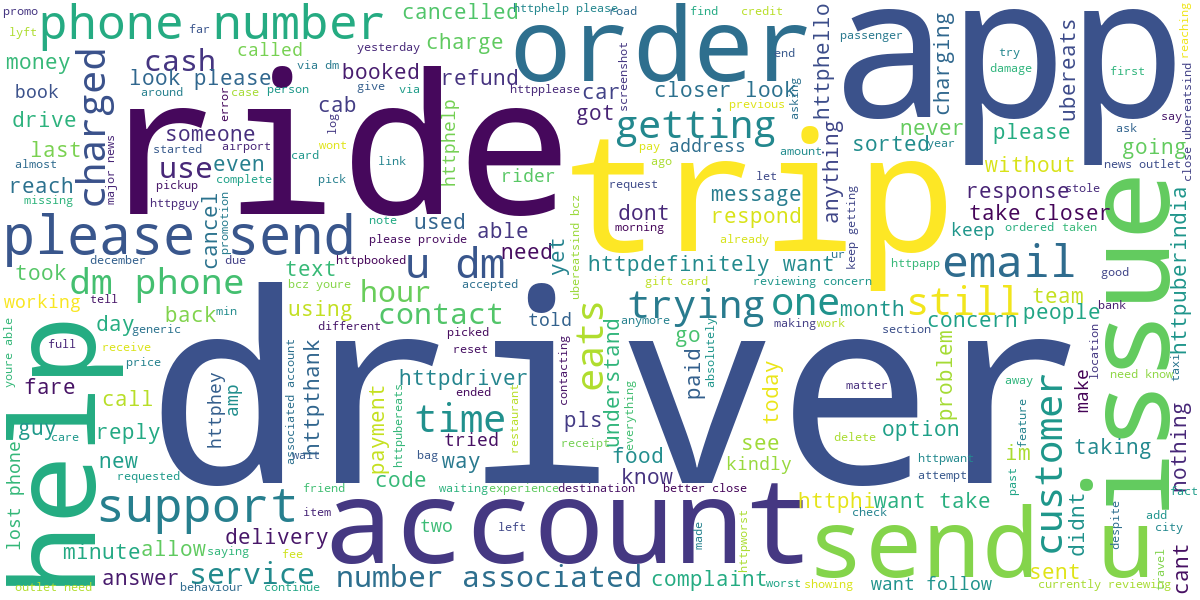

In [71]:
wcloud

In [72]:
LDAvis_prepared = lda(pre_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.037*"http" + 0.018*"get" + 0.014*"u" + 0.014*"driver" + 0.010*"delivery" + 0.010*"order" + 0.010*"food" + 0.009*"last" + 0.008*"help" + 0.008*"need"'), (1, '0.074*"http" + 0.017*"help" + 0.015*"phone" + 0.014*"account" + 0.012*"number" + 0.010*"app" + 0.010*"im" + 0.010*"driver" + 0.010*"hour" + 0.010*"email"'), (2, '0.081*"http" + 0.032*"please" + 0.020*"order" + 0.013*"u" + 0.013*"trip" + 0.013*"dm" + 0.013*"look" + 0.012*"help" + 0.011*"account" + 0.010*"number"'), (3, '0.057*"http" + 0.019*"phone" + 0.015*"account" + 0.013*"lost" + 0.009*"hi" + 0.009*"driver" + 0.007*"help" + 0.007*"email" + 0.007*"complaint" + 0.007*"ubereats"'), (4, '0.067*"http" + 0.017*"get" + 0.014*"driver" + 0.014*"want" + 0.013*"app" + 0.012*"like" + 0.011*"u" + 0.010*"number" + 0.010*"phone" + 0.010*"know"'), (5, '0.076*"http" + 0.043*"driver" + 0.024*"ride" + 0.014*"please" + 0.013*"trip" + 0.011*"help" + 0.011*"app" + 0.010*"charged" + 0.009*"dm" + 0.008*"u"'), (6, '0.036*"http" + 0.023*"t

In [73]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.077548 -0.063843       1        1  15.969454
5     -0.039089 -0.038173       2        1  13.997388
8     -0.021332 -0.053328       3        1  12.829282
4     -0.084507  0.048479       4        1  12.269123
1      0.001465 -0.055931       5        1   9.417735
9      0.002690  0.060249       6        1   8.429245
7      0.032517  0.038070       7        1   8.367992
3      0.138029  0.007192       8        1   6.738692
0     -0.017770  0.114618       9        1   6.523849
6      0.065544 -0.057332      10        1   5.457241, topic_info=        Term       Freq      Total Category  logprob  loglift
183     trip  43.000000  43.000000  Default  30.0000  30.0000
35    please  80.000000  80.000000  Default  29.0000  29.0000
142     ride  42.000000  42.000000  Default  28.0000  28.0000
168   driver  91.000000  91.000000  Default  27.0000  27.0000
40       get  38.000000  38.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
30      want   1.595880  39.401229  Topic10  -5.2961  -0.2981
168   driver   1.595870  91.407353  Topic10  -5.2962  -1.1397
277  contact   1.595865  16.943691  Topic10  -5.2962   0.5457
84       guy   1.595825  14.179093  Topic10  -5.2962   0.7238
312      way   1.595815  12.812182  Topic10  -5.2962   0.8252

[726 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
440       1  0.261830   able
440       2  0.052366   able
440       3  0.157098   able
440       6  0.157098   able
440       7  0.157098   able
...     ...       ...    ...
546       3  0.179314  youre
546       6  0.358628  youre
546       8  0.358628  youre
439       2  0.221160  youve
439       5  0.663480  youve

[1384 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 9, 5, 2, 10, 8, 4, 1, 7])

In [74]:
pyLDAvis.save_html(LDAvis_prepared,'./html/pre_lda_n{}.html'.format(n_topics))

# Post-COVID

In [75]:
post_uber_df_tk = uber_df_tk[uber_df_tk['created_at'] > covid_date]

In [76]:
post_uber_df_tk

,source,source_id,target,target_id,type_of_content,created_at,all_data,text,sentiments,Convo
664,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[sorry, hear, experience, would, like, follow,...",0.133,Uber_Support fltrtae
665,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[sorry, hear, experience, would, like, follow,...",0.133,Uber_Support fltrtae
666,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[sorry, hear, experience, would, like, follow,...",0.133,Uber_Support fltrtae
667,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[sorry, hear, experience, would, like, follow,...",0.133,Uber_Support fltrtae
668,Uber_Support,2815754953,fltrtae,1242683484704915457,Reply,2020-10-17 10:27:36,{'created_at': 'Sat Oct 17 10:27:36 +0000 2020...,"[sorry, hear, experience, would, like, follow,...",0.133,Uber_Support fltrtae
...,...,...,...,...,...,...,...,...,...,...
5563,ajb_neuk,1344742630731747328,Uber_Support,2815754953,Reply,2021-03-31 17:15:48,{'created_at': 'Wed Mar 31 17:15:48 +0000 2021...,"[yeah, cause, link, useful, support, quick, lo...",0.154,Uber_Support ajb_neuk
5564,AdrianMatache7,1376698104028794882,Uber_Support,2815754953,Reply,2021-03-31 17:18:34,{'created_at': 'Wed Mar 31 17:18:34 +0000 2021...,"[hi, guy, long, take, bank, account, reviewed,...",0.000,AdrianMatache7 Uber_Support
5565,k_sovs,1369169148580823040,Uber_Support,2815754953,Reply,2021-03-31 17:19:01,{'created_at': 'Wed Mar 31 17:19:01 +0000 2021...,"[filled, form, many, time, response]",0.000,Uber_Support k_sovs
5566,MY0U1SANA,918655647763324928,Uber_Support,2815754953,Reply,2021-03-31 17:22:01,{'created_at': 'Wed Mar 31 17:22:01 +0000 2021...,"[fltrtae, hold]",0.000,MY0U1SANA Uber_Support


In [77]:
wcloud = word_cloud(post_uber_df_tk)

Total words 251572


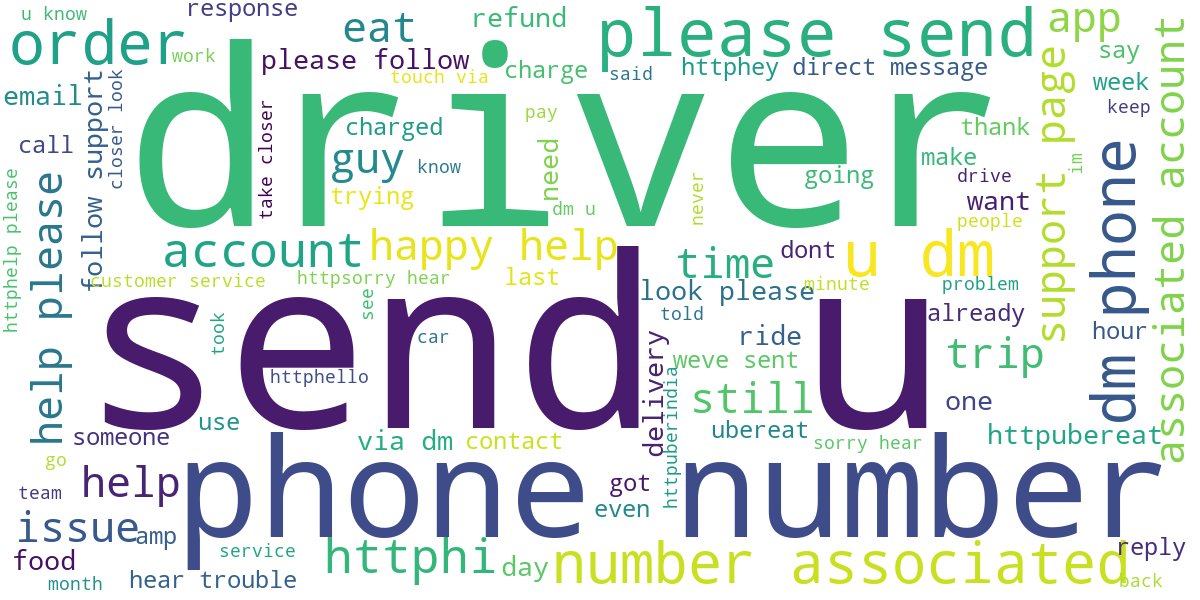

In [78]:
wcloud

In [79]:
LDAvis_prepared = lda(post_uber_df_tk, n_topics=n_topics)


Topics
[(0, '0.093*"http" + 0.021*"driver" + 0.017*"help" + 0.017*"please" + 0.016*"support" + 0.014*"ride" + 0.012*"hi" + 0.011*"happy" + 0.010*"follow" + 0.010*"trip"'), (1, '0.057*"http" + 0.023*"help" + 0.017*"please" + 0.016*"uberindia" + 0.012*"need" + 0.011*"get" + 0.011*"ride" + 0.010*"driver" + 0.010*"go" + 0.010*"thanks"'), (2, '0.052*"http" + 0.018*"help" + 0.018*"want" + 0.014*"get" + 0.011*"please" + 0.010*"phone" + 0.009*"ordered" + 0.008*"food" + 0.007*"response" + 0.007*"service"'), (3, '0.072*"http" + 0.014*"driver" + 0.012*"please" + 0.010*"get" + 0.009*"sent" + 0.009*"app" + 0.009*"service" + 0.008*"ride" + 0.007*"help" + 0.007*"hey"'), (4, '0.066*"http" + 0.047*"dm" + 0.045*"u" + 0.045*"please" + 0.041*"send" + 0.040*"phone" + 0.038*"number" + 0.026*"associated" + 0.026*"account" + 0.016*"help"'), (5, '0.075*"http" + 0.022*"please" + 0.015*"time" + 0.014*"order" + 0.013*"dm" + 0.013*"account" + 0.013*"u" + 0.010*"thanks" + 0.010*"number" + 0.009*"send"'), (6, '0.08

In [80]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.147122  0.010269       1        1  15.859522
9     -0.002005  0.016747       2        1  14.013844
7     -0.041089 -0.037843       3        1  12.488822
0      0.014541 -0.088836       4        1  10.250754
6     -0.041436  0.010811       5        1  10.074345
8      0.048073  0.075603       6        1   9.699244
3      0.080615  0.054778       7        1   7.652691
5     -0.023507  0.009271       8        1   7.497312
1      0.082429 -0.086997       9        1   6.326881
2      0.029501  0.036197      10        1   6.136584, topic_info=           Term        Freq       Total Category  logprob  loglift
23         send  404.000000  404.000000  Default  30.0000  30.0000
24            u  552.000000  552.000000  Default  29.0000  29.0000
21        phone  427.000000  427.000000  Default  28.0000  28.0000
18           dm  660.000000  660.000000  Default  27.0000  27.0000
17   associated  245.000000  245.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
20       number   13.909262  451.288662  Topic10  -5.1565  -0.6887
214         guy   11.125184  119.310602  Topic10  -5.3798   0.4184
71       driver   12.768061  516.319873  Topic10  -5.2421  -0.9089
24            u   12.335967  552.223130  Topic10  -5.2765  -1.0105
369        need   11.095324  171.958650  Topic10  -5.3825   0.0502

[804 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3566      6  0.867276  aampress
179       1  0.126251      able
179       2  0.090180      able
179       3  0.144287      able
179       4  0.252503      able
...     ...       ...       ...
348      10  0.177567       yet
2103     10  0.500711       yhe
1288      2  0.631781      youd
1722      4  0.755745        yr
74        3  0.821072      zaid

[2291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 8, 1, 7, 9, 4, 6, 2, 3])

In [81]:
pyLDAvis.save_html(LDAvis_prepared,'./html/post_lda_n{}.html'.format(n_topics))